# ***COVID-19 propagation: analysis and experimentation***
*Analysis and modeling: Louay Farah*

# Dataset

https://covid19.who.int/WHO-COVID-19-global-data.csv

# Importing libraries and modules

In [1186]:
import pandas as pd                  #For data exploration and preprocessing
import numpy as np                   #For data manipulation
import matplotlib.pyplot as plt      #For data plotting

from sklearn.model_selection import train_test_split #For splitting data
from sklearn.linear_model import LinearRegression    #For creating regression models
from sklearn.preprocessing import PolynomialFeatures #For fitting features to polynomial regression model
from sklearn.metrics import mean_squared_error       #For calculating MSE
from sklearn.metrics import r2_score                 #For calculationg R-squared scores

# Loading Dataset

In [1187]:
#Loading the 'WHO-COVID-19-global-data.csv' dataset that contains comma-seperated values, and saving it as a data frame called 'df'.
df=pd.read_csv('WHO-COVID-19-global-data.csv', sep=',')    

In [1188]:
#Printing a part of the dataset
df

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0
2,2020-01-05,AF,Afghanistan,EMRO,0,0,0,0
3,2020-01-06,AF,Afghanistan,EMRO,0,0,0,0
4,2020-01-07,AF,Afghanistan,EMRO,0,0,0,0
...,...,...,...,...,...,...,...,...
135322,2021-07-22,ZW,Zimbabwe,AFRO,2705,91120,62,2809
135323,2021-07-23,ZW,Zimbabwe,AFRO,2301,93421,61,2870
135324,2021-07-24,ZW,Zimbabwe,AFRO,2265,95686,91,2961
135325,2021-07-25,ZW,Zimbabwe,AFRO,1591,97277,89,3050


# Dataset exploration and preprocessing

In [1189]:
#printing the first 5 rows of the dataset
df.head()     

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0
2,2020-01-05,AF,Afghanistan,EMRO,0,0,0,0
3,2020-01-06,AF,Afghanistan,EMRO,0,0,0,0
4,2020-01-07,AF,Afghanistan,EMRO,0,0,0,0


In [1190]:
#printing the last 5 rows of the dataset
df.tail()     

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
135322,2021-07-22,ZW,Zimbabwe,AFRO,2705,91120,62,2809
135323,2021-07-23,ZW,Zimbabwe,AFRO,2301,93421,61,2870
135324,2021-07-24,ZW,Zimbabwe,AFRO,2265,95686,91,2961
135325,2021-07-25,ZW,Zimbabwe,AFRO,1591,97277,89,3050
135326,2021-07-26,ZW,Zimbabwe,AFRO,617,97894,44,3094


In [1191]:
#Getting informations about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135327 entries, 0 to 135326
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Date_reported      135327 non-null  object
 1   Country_code       134756 non-null  object
 2   Country            135327 non-null  object
 3   WHO_region         135327 non-null  object
 4   New_cases          135327 non-null  int64 
 5   Cumulative_cases   135327 non-null  int64 
 6   New_deaths         135327 non-null  int64 
 7   Cumulative_deaths  135327 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 8.3+ MB


In [1192]:
#Making sure all countries are represented with the same weight
df.iloc[:,2].value_counts().describe() 

count    237.0
mean     571.0
std        0.0
min      571.0
25%      571.0
50%      571.0
75%      571.0
max      571.0
Name: Country, dtype: float64

In [1193]:
#Showing the features that contain NaN values.
df.isnull().sum()        
#We can see that only the Country_code feature contains NaN values.

Date_reported          0
Country_code         571
Country                0
WHO_region             0
New_cases              0
Cumulative_cases       0
New_deaths             0
Cumulative_deaths      0
dtype: int64

In [1194]:
#Making sure all countries have the same number of observations.
result=False
l=df.iloc[:,2].value_counts().tolist()
if len(l)>0:
  result = all(elem == l[0] for elem in l)

assert result    

In [1195]:
df[df.iloc[:,1].isnull()].iloc[:,2].value_counts()
#Namibia is the only country without a country code.

Namibia    571
Name: Country, dtype: int64

In [1196]:
#Making sure NM is not used as a country code.
df[df.iloc[:,1]=='NM']   

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths


In [1197]:
#Replacing NaN values in Namibia Country_code feature by 'NM'
df.fillna('NM', inplace=True)
df[df.iloc[:,2]=='Namibia'].iloc[:,1]

81653    NM
81654    NM
81655    NM
81656    NM
81657    NM
         ..
82219    NM
82220    NM
82221    NM
82222    NM
82223    NM
Name: Country_code, Length: 571, dtype: object

In [1198]:
#Counting the number of regions and countries where the observations were made.
print(df.iloc[:,3].value_counts(),'\n')
print('Observations have been made on {0} regions and {1} countries.'.format(len(df.iloc[:,3].value_counts().index), len(df.iloc[:,2].value_counts().index)))
countries=len(df.iloc[:,2].value_counts().index)
obs=(len(df)//countries)
print('Number of observations: {}'.format(obs))

EURO     35402
AMRO     31976
AFRO     28550
WPRO     19985
EMRO     12562
SEARO     6281
Other      571
Name: WHO_region, dtype: int64 

Observations have been made on 7 regions and 237 countries.
Number of observations: 571


In [1199]:
#Making sure the is no more NaN values in the dataset.
df.isnull().sum().sum()   

0

# 1: Creating COVID-19 Global prediction models

**Understanding data, preprocessing and Visualization**

In [1200]:
#Printing the first 5 rows of the dataset.
df.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0
2,2020-01-05,AF,Afghanistan,EMRO,0,0,0,0
3,2020-01-06,AF,Afghanistan,EMRO,0,0,0,0
4,2020-01-07,AF,Afghanistan,EMRO,0,0,0,0


In [1201]:
#creating a data frame called 'df_nc' to store New_cases feature evolution.
df_nc=df.iloc[:, [4,0]]

In [1202]:
#Printing the first 5 rows of 'df_nc'
df_nc.head()

,New_cases,Date_reported
0,0,2020-01-03
1,0,2020-01-04
2,0,2020-01-05
3,0,2020-01-06
4,0,2020-01-07


In [1203]:
#Getting a description of 'df_nc'.
df_nc.describe()

,New_cases
count,135327.000000
mean,1434.155926
std,9453.335294
min,-32952.000000
25%,0.000000
50%,9.000000
75%,311.000000
max,414188.000000


In [1204]:
#creating a data frame called 'df_cc' to store Cumulative_cases feature evolution.
df_cc=df.iloc[:, [5,0]]

In [1205]:
#Printing the first 5 rows of 'df_cc'
df_cc.head()

,Cumulative_cases,Date_reported
0,0,2020-01-03
1,0,2020-01-04
2,0,2020-01-05
3,0,2020-01-06
4,0,2020-01-07


In [1206]:
#Getting a description of 'df_cc'.
df_cc.describe()

,Cumulative_cases
count,1.353270e+05
mean,2.703228e+05
std,1.665163e+06
min,0.000000e+00
25%,2.400000e+01
50%,3.080000e+03
75%,5.801950e+04
max,3.422349e+07


In [1207]:
#creating a data frame called 'df_nd' to store New_deaths feature evolution.
df_nd=df.iloc[:, [6,0]]

In [1208]:
#Printing the first 5 rows of 'df_nd'
df_nd.head()

,New_deaths,Date_reported
0,0,2020-01-03
1,0,2020-01-04
2,0,2020-01-05
3,0,2020-01-06
4,0,2020-01-07


In [1209]:
#Getting a description of 'df_nd'.
df_nd.describe()

,New_deaths
count,135327.000000
mean,30.757380
std,171.900704
min,-60.000000
25%,0.000000
50%,0.000000
75%,5.000000
max,8786.000000


In [1210]:
#creating a data frame called 'df_cd' to store Cumulative_deaths feature evolution.
df_cd=df.iloc[:, [7,0]]

In [1211]:
#Printing the first 5 rows of 'df_cd'
df_cd.head()

,Cumulative_deaths,Date_reported
0,0,2020-01-03
1,0,2020-01-04
2,0,2020-01-05
3,0,2020-01-06
4,0,2020-01-07


In [1212]:
#Getting a description of 'df_nd'.
df_cd.describe()

,Cumulative_deaths
count,135327.000000
mean,6435.238652
std,33413.271312
min,0.000000
25%,0.000000
50%,50.000000
75%,929.000000
max,605656.000000


In [1213]:
#Writing a function that, given a data frame, gets the sum of cases or deaths of all countries, stores the information in a new data frame, and returns it. 
def sumCasesOrDeaths(df):
  i=0
  df1=df.iloc[i:i+obs,:]
  i+=obs
  for country in range(1,countries):
    value=0
    d={}
    for key in range(i,i+obs):
      d[key]=value
      value+=1
    df1=df1+(df.iloc[i:i+obs,:].rename(index=d))
    i+=obs
  return df1  

In [1214]:
#Creating the new 'df_nc' dataframe using the sumCasesOrDeaths function.
df_nc1=sumCasesOrDeaths(df_nc)
df_nc1=df_nc1.drop('Date_reported', axis = 1)
df_nc1['day_index']=[i for i in range(1,obs+1)]

In [1215]:
print(df_nc1)

     New_cases  day_index
0            0          1
1            1          2
2            0          3
3            3          4
4            0          5
..         ...        ...
566     696875        567
567     556946        568
568     544714        569
569     586079        570
570     422294        571

[571 rows x 2 columns]


In [1216]:
#Creating the new 'df_cc' dataframe using the sumCasesOrDeaths function.
df_cc1=sumCasesOrDeaths(df_cc)
df_cc1=df_cc1.drop('Date_reported', axis = 1)
df_cc1['day_index']=[i for i in range(1,obs+1)]

In [1217]:
print(df_cc1)

     Cumulative_cases  day_index
0                   0          1
1                   1          2
2                   1          3
3                   4          4
4                   4          5
..                ...        ...
566         191969986        567
567         192526932        568
568         193071646        569
569         193657725        570
570         194080019        571

[571 rows x 2 columns]


In [1218]:
#Creating the new 'df_nd' dataframe using the sumCasesOrDeaths function.
df_nd1=sumCasesOrDeaths(df_nd)
df_nd1=df_nd1.drop('Date_reported', axis = 1)
df_nd1['day_index']=[i for i in range(1,obs+1)]

In [1219]:
print(df_nd1)

     New_deaths  day_index
0             0          1
1             0          2
2             0          3
3             0          4
4             0          5
..          ...        ...
566        8708        567
567        9024        568
568        8826        569
569        8662        570
570        7644        571

[571 rows x 2 columns]


In [1220]:
#Creating the new 'df_cd' dataframe using the sumCasesOrDeaths function.
df_cd1=sumCasesOrDeaths(df_cd)
df_cd1=df_cd1.drop('Date_reported', axis = 1)
df_cd1['day_index']=[i for i in range(1,obs+1)]

In [1221]:
print(df_cd1)

     Cumulative_deaths  day_index
0                    0          1
1                    0          2
2                    0          3
3                    0          4
4                    0          5
..                 ...        ...
566            4128148        567
567            4137172        568
568            4145998        569
569            4154660        570
570            4162304        571

[571 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


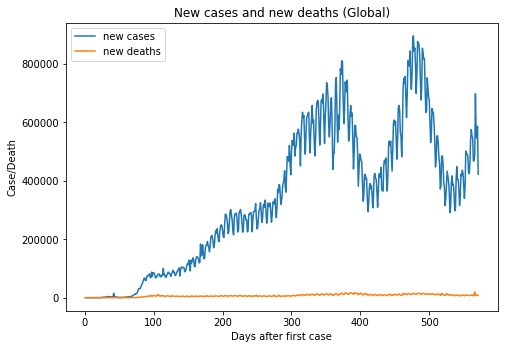

In [1222]:
#Plotting New_cases and New_deaths
fig1=plt.figure()
ax1=fig1.add_axes([0,0,1,1])
ax2=fig1.add_axes([0,0,1,1])
ax1.plot(df_nc1['day_index'],df_nc1.iloc[:,0],label='new cases')
ax2.plot(df_nd1['day_index'],df_nd1.iloc[:,0],label='new deaths')
plt.title('New cases and new deaths (Global)')
plt.xlabel('Days after first case')
plt.ylabel('Case/Death')
ax1.legend()
ax2.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


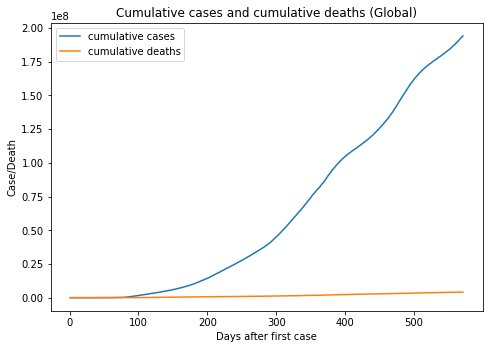

In [1223]:
#Plotting Cumulative_cases and Cumulative_deaths
fig2=plt.figure()
ax3=fig2.add_axes([0,0,1,1])
ax4=fig2.add_axes([0,0,1,1])
ax3.plot(df_cc1['day_index'],df_cc1.iloc[:,0],label='cumulative cases')
ax4.plot(df_cd1['day_index'],df_cd1.iloc[:,0],label='cumulative deaths')
plt.title('Cumulative cases and cumulative deaths (Global)')
plt.xlabel('Days after first case')
plt.ylabel('Case/Death')
ax3.legend()
ax4.legend()

**Choosing the right algorithm:**
According to the graphs, there is a polynomial relationship between day_index feature and the targets: New_cases, New_deaths, Cumulative_cases and Cumulative_deaths.

**Modeling:**

*new cases*

In [1224]:
#choosing the target and the feature
x_nc=df_nc1.iloc[:,[1]].values
y_nc=df_nc1.iloc[:,[0]].values

In [1225]:
#splitting the data
x_train_nc,x_test_nc,y_train_nc,y_test_nc=train_test_split(x_nc,y_nc,test_size=0.30,random_state=40)

In [1226]:
#fitting the feature
poly_nc=PolynomialFeatures(degree=6)

x_train_nc_fit=poly_nc.fit_transform(x_train_nc)
x_test_nc_fit=poly_nc.fit_transform(x_test_nc)

In [1227]:
#creating the regression model
model_nc=LinearRegression()
model_nc.fit(x_train_nc_fit, y_train_nc)

print('score:')
model_nc.score(x_test_nc_fit, y_test_nc)

score:


0.8040259915093139

In [1228]:
#calculating metrics
pred_nc=model_nc.predict(x_test_nc_fit)
print("MSE:", mean_squared_error(y_test_nc,pred_nc))
print("R2:", r2_score(y_test_nc,pred_nc))

MSE: 12298336902.310383
R2: 0.8040259915093139


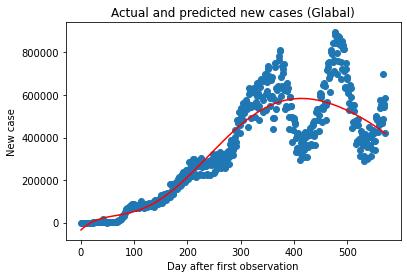

In [1229]:
#plotting the model
fig3=plt.figure()
plt.scatter(x_nc,y_nc)
plt.title("Actual and predicted new cases (Glabal)")
plt.xlabel("Day after first observation")
plt.ylabel("New case")
plt.plot(x_nc, model_nc.predict(poly_nc.fit_transform(x_nc)), color="r")

*Cumulative cases*

In [1230]:
#choosing the target and the feature
x_cc=df_cc1.iloc[:,[1]].values
y_cc=df_cc1.iloc[:,[0]].values

In [1231]:
#splitting the data
x_train_cc,x_test_cc,y_train_cc,y_test_cc=train_test_split(x_cc,y_cc,test_size=0.30,random_state=40)

In [1232]:
#fitting the feature
poly_cc=PolynomialFeatures(degree=2)

x_train_cc_fit=poly_cc.fit_transform(x_train_cc)
x_test_cc_fit=poly_cc.fit_transform(x_test_cc)

In [1233]:
#creating the regression model
model_cc=LinearRegression()
model_cc.fit(x_train_cc_fit, y_train_cc)

print('score:')
model_cc.score(x_test_cc_fit, y_test_cc)

score:


0.9951857393896556

In [1234]:
#calculating metrics
pred_cc=model_cc.predict(x_test_cc_fit)
print("MSE:", mean_squared_error(y_test_cc,pred_cc))
print("R2:", r2_score(y_test_cc,pred_cc))

MSE: 19675769184660.504
R2: 0.9951857393896556


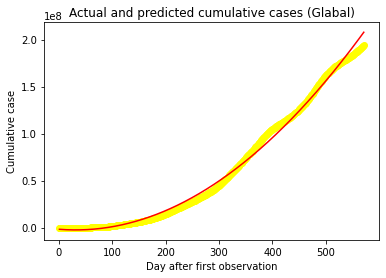

In [1235]:
#plotting the model
fig4=plt.figure()
plt.scatter(x_cc,y_cc, c='yellow')
plt.title("Actual and predicted cumulative cases (Glabal)")
plt.xlabel("Day after first observation")
plt.ylabel("Cumulative case")
plt.plot(x_cc, model_cc.predict(poly_cc.fit_transform(x_cc)), color="r")

*new deaths*

In [1236]:
#choosing the target and the feature
x_nd=df_nd1.iloc[:,[1]].values
y_nd=df_nd1.iloc[:,[0]].values

In [1237]:
#splitting the data
x_train_nd,x_test_nd,y_train_nd,y_test_nd=train_test_split(x_nd,y_nd,test_size=0.30,random_state=40)

In [1238]:
#fitting the feature
poly_nd=PolynomialFeatures(degree=6)

x_train_nd_fit=poly_nd.fit_transform(x_train_nd)
x_test_nd_fit=poly_nd.fit_transform(x_test_nd)

In [1239]:
#creating the regression model
model_nd=LinearRegression()
model_nd.fit(x_train_nd_fit, y_train_nd)

print('score:')
model_nd.score(x_test_nd_fit, y_test_nd)

score:


0.8041299170297584

In [1240]:
#calculating metrics
pred_nd=model_nd.predict(x_test_nd_fit)
print("MSE:", mean_squared_error(y_test_nd,pred_nd))
print("R2:", r2_score(y_test_nd,pred_nd))

MSE: 3487498.763821405
R2: 0.8041299170297584


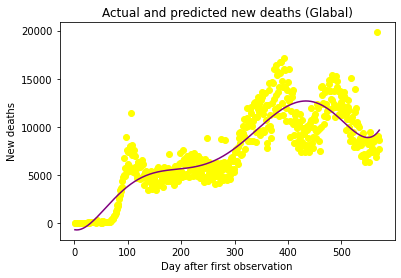

In [1241]:
#plotting the model
fig5=plt.figure()
plt.scatter(x_nd,y_nd, c='yellow')
plt.title("Actual and predicted new deaths (Glabal)")
plt.xlabel("Day after first observation")
plt.ylabel("New deaths")
plt.plot(x_nd, model_nd.predict(poly_nd.fit_transform(x_nd)), color="purple")

*Cumulative deaths*

In [1242]:
#choosing the target and the feature
x_cd=df_cd1.iloc[:,[1]].values
y_cd=df_cd1.iloc[:,[0]].values

In [1243]:
#splitting the data
x_train_cd,x_test_cd,y_train_cd,y_test_cd=train_test_split(x_cd,y_cd,test_size=0.30,random_state=40)

In [1244]:
#fitting the feature
poly_cd=PolynomialFeatures(degree=2)

x_train_cd_fit=poly_cd.fit_transform(x_train_cd)
x_test_cd_fit=poly_cd.fit_transform(x_test_cd)

In [1245]:
#creating the regression model
model_cd=LinearRegression()
model_cd.fit(x_train_cd_fit, y_train_cd)

print('score:')
model_cd.score(x_test_cd_fit, y_test_cd)

score:


0.9976738946963961

In [1246]:
#calculating metrics
pred_cd=model_cd.predict(x_test_cd_fit)
print("MSE:", mean_squared_error(y_test_cd,pred_cd))
print("R2:", r2_score(y_test_cd,pred_cd))

MSE: 4099600955.0486917
R2: 0.9976738946963961


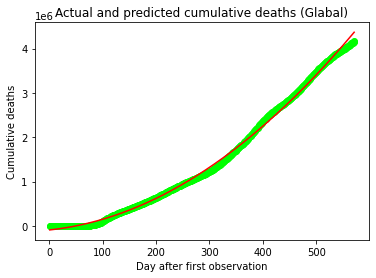

In [1247]:
#plotting the model
fig6=plt.figure()
plt.scatter(x_cd,y_cd, c='lime')
plt.title("Actual and predicted cumulative deaths (Glabal)")
plt.xlabel("Day after first observation")
plt.ylabel("Cumulative deaths")
plt.plot(x_cd, model_cd.predict(poly_cd.fit_transform(x_cd)), color="red")

# 2: Creating COVID-19 local prediction models (Tunisia)

**Understanding data, preprocessing and Visualization**

In [1248]:
#Printing the first 5 rows of the dataset
df.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0
2,2020-01-05,AF,Afghanistan,EMRO,0,0,0,0
3,2020-01-06,AF,Afghanistan,EMRO,0,0,0,0
4,2020-01-07,AF,Afghanistan,EMRO,0,0,0,0


In [1249]:
#Creating a new data frame called 'dft' that contains information about COVID-19 propagation in Tunisia.
#Printing some rows of 'dft'
dft=df[df.iloc[:,1]=='TN']
dft

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
123907,2020-01-03,TN,Tunisia,EMRO,0,0,0,0
123908,2020-01-04,TN,Tunisia,EMRO,0,0,0,0
123909,2020-01-05,TN,Tunisia,EMRO,0,0,0,0
123910,2020-01-06,TN,Tunisia,EMRO,0,0,0,0
123911,2020-01-07,TN,Tunisia,EMRO,0,0,0,0
...,...,...,...,...,...,...,...,...
124473,2021-07-22,TN,Tunisia,EMRO,1086,555997,92,17913
124474,2021-07-23,TN,Tunisia,EMRO,2309,558306,139,18052
124475,2021-07-24,TN,Tunisia,EMRO,5624,563930,317,18369
124476,2021-07-25,TN,Tunisia,EMRO,5359,569289,231,18600


In [1250]:
#Creating two variables 'start' and 'stop' that represent the first data frame index and the last data frame index, respectively.
start=dft.index[0]
stop=dft.index[-1]

In [1251]:
#Creating a map called 'dt'.
value_t=0
dt={}
for key in range(start, (stop+1)):
  dt[key]=value_t
  value_t+=1

In [1252]:
#changing 'dft' indexes, by the mapped sequence contained in 'dt'.
dft=dft.rename(index=dt)

In [1253]:
#Creating a new feature called day_index.
dft['day_index']=[i for i in range(1,obs+1)]

In [1254]:
#creating a data frame called 'dft_nc' to store New_cases feature evolution in Tunisia.
dft_nc=dft.iloc[:,[4,8]]

In [1255]:
print(dft_nc)

     New_cases  day_index
0            0          1
1            0          2
2            0          3
3            0          4
4            0          5
..         ...        ...
566       1086        567
567       2309        568
568       5624        569
569       5359        570
570          0        571

[571 rows x 2 columns]


In [1256]:
#Getting a description of 'dft_nc'.
dft_nc.describe()

,New_cases,day_index
count,571.000000,571.000000
mean,997.003503,286.000000
std,1513.738729,164.977776
min,-5.000000,1.000000
25%,4.000000,143.500000
50%,496.000000,286.000000
75%,1435.500000,428.500000
max,9823.000000,571.000000


In [1257]:
#creating a data frame called 'dft_cc' to store Cumulative_cases feature evolution in Tunisia.
dft_cc=dft.iloc[:,[5,8]]

In [1258]:
print(dft_cc)

     Cumulative_cases  day_index
0                   0          1
1                   0          2
2                   0          3
3                   0          4
4                   0          5
..                ...        ...
566            555997        567
567            558306        568
568            563930        569
569            569289        570
570            569289        571

[571 rows x 2 columns]


In [1259]:
#Getting a description of 'dft_cc'.
dft_cc.describe()

,Cumulative_cases,day_index
count,571.000000,571.000000
mean,121749.197898,286.000000
std,150130.814738,164.977776
min,0.000000,1.000000
25%,1049.500000,143.500000
50%,34790.000000,286.000000
75%,235999.500000,428.500000
max,569289.000000,571.000000


In [1260]:
#creating a data frame called 'dft_nd' to store New_deaths feature evolution in Tunisia.
dft_nd=dft.iloc[:,[6,8]]

In [1261]:
print(dft_nd)

     New_deaths  day_index
0             0          1
1             0          2
2             0          3
3             0          4
4             0          5
..          ...        ...
566          92        567
567         139        568
568         317        569
569         231        570
570           0        571

[571 rows x 2 columns]


In [1262]:
#Getting a description of 'dft_nd'.
dft_nd.describe()

,New_deaths,day_index
count,571.000000,571.000000
mean,32.574431,286.000000
std,41.937037,164.977776
min,0.000000,1.000000
25%,0.000000,143.500000
50%,16.000000,286.000000
75%,56.000000,428.500000
max,317.000000,571.000000


In [1263]:
#creating a data frame called 'dft_cd' to store Cumulative_deaths feature evolution in Tunisia.
dft_cd=dft.iloc[:,[7,8]]

In [1264]:
print(dft_cd)

     Cumulative_deaths  day_index
0                    0          1
1                    0          2
2                    0          3
3                    0          4
4                    0          5
..                 ...        ...
566              17913        567
567              18052        568
568              18369        569
569              18600        570
570              18600        571

[571 rows x 2 columns]


In [1265]:
#Getting a description of 'dft_cd'.
dft_cd.describe()

,Cumulative_deaths,day_index
count,571.000000,571.000000
mean,4135.711033,286.000000
std,5226.416334,164.977776
min,0.000000,1.000000
25%,48.000000,143.500000
50%,512.000000,286.000000
75%,8118.000000,428.500000
max,18600.000000,571.000000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


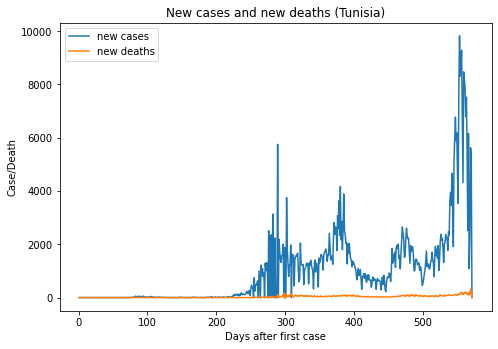

In [1266]:
#Plotting New_cases and New_deaths
fig7=plt.figure()
ax5=fig7.add_axes([0,0,1,1])
ax6=fig7.add_axes([0,0,1,1])
ax5.plot(dft_nc['day_index'],dft_nc.iloc[:,0],label='new cases')
ax6.plot(dft_nd['day_index'],dft_nd.iloc[:,0],label='new deaths')
plt.title('New cases and new deaths (Tunisia)')
plt.xlabel('Days after first case')
plt.ylabel('Case/Death')
ax5.legend()
ax6.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


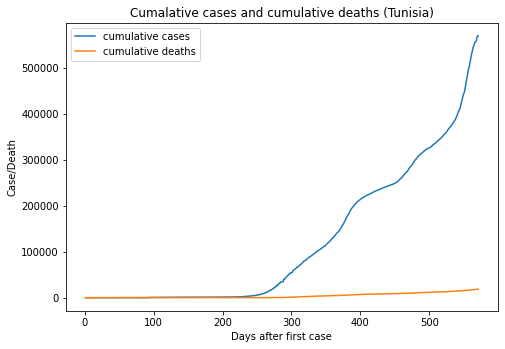

In [1267]:
#Plotting Cumulative_cases and Cumulative_deaths
fig8=plt.figure()
ax7=fig8.add_axes([0,0,1,1])
ax8=fig8.add_axes([0,0,1,1])
ax7.plot(dft_cc['day_index'],dft_cc.iloc[:,0],label='cumulative cases')
ax8.plot(dft_cd['day_index'],dft_cd.iloc[:,0],label='cumulative deaths')
plt.title('Cumalative cases and cumulative deaths (Tunisia)')
plt.xlabel('Days after first case')
plt.ylabel('Case/Death')
ax7.legend()
ax8.legend()

**Choosing the right algorithm:**
According to the graphs, there is a polynomial relationship between day_index feature and the targets: New_cases, New_deaths, Cumulative_cases and Cumulative_deaths.

**Modeling**

*new cases*

In [1268]:
#choosing the target and the feature
xt_nc=dft_nc.iloc[:,[1]].values
yt_nc=dft_nc.iloc[:,[0]].values

In [1269]:
#splitting the data
xt_train_nc,xt_test_nc,yt_train_nc,yt_test_nc=train_test_split(xt_nc,yt_nc,test_size=0.30,random_state=40)

In [1270]:
#fitting the feature
polyt_nc=PolynomialFeatures(degree=4)

xt_train_nc_fit=polyt_nc.fit_transform(xt_train_nc)
xt_test_nc_fit=polyt_nc.fit_transform(xt_test_nc)

In [1271]:
#creating the regression model
modelt_nc=LinearRegression()
modelt_nc.fit(xt_train_nc_fit, yt_train_nc)

print('score:')
modelt_nc.score(xt_test_nc_fit, yt_test_nc)

score:


0.6503410356264918

In [1272]:
#calculating metrics
predt_nc=modelt_nc.predict(xt_test_nc_fit)
print("MSE:", mean_squared_error(yt_test_nc,predt_nc))
print("R2:", r2_score(yt_test_nc,predt_nc))

MSE: 684565.9962545004
R2: 0.6503410356264918


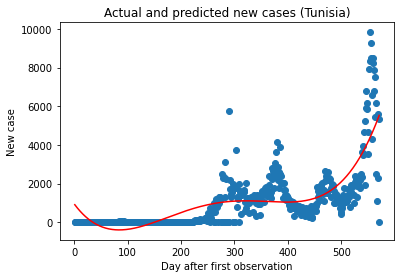

In [1273]:
#plotting the model
fig9=plt.figure()
plt.scatter(xt_nc,yt_nc)
plt.title("Actual and predicted new cases (Tunisia)")
plt.xlabel("Day after first observation")
plt.ylabel("New case")
plt.plot(xt_nc, modelt_nc.predict(polyt_nc.fit_transform(xt_nc)), color="r")

*cumulative cases*

In [1274]:
#choosing the target and the feature
xt_cc=dft_cc.iloc[:,[1]].values
yt_cc=dft_cc.iloc[:,[0]].values

In [1275]:
#splitting the data
xt_train_cc,xt_test_cc,yt_train_cc,yt_test_cc=train_test_split(xt_cc,yt_cc,test_size=0.30,random_state=40)

In [1276]:
#fitting the feature
polyt_cc=PolynomialFeatures(degree=2)

xt_train_cc_fit=polyt_cc.fit_transform(xt_train_cc)
xt_test_cc_fit=polyt_cc.fit_transform(xt_test_cc)

In [1277]:
#creating the regression model
modelt_cc=LinearRegression()
modelt_cc.fit(xt_train_cc_fit, yt_train_cc)

print('score:')
modelt_cc.score(xt_test_cc_fit, yt_test_cc)

score:


0.9840172348644103

In [1278]:
#calculating metrics
predt_cc=modelt_cc.predict(xt_test_cc_fit)
print("MSE:", mean_squared_error(yt_test_cc,predt_cc))
print("R2:", r2_score(yt_test_cc,predt_cc))

MSE: 350949595.47945124
R2: 0.9840172348644103


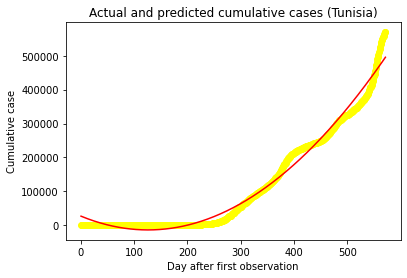

In [1279]:
#plotting the model
fig10=plt.figure()
plt.scatter(xt_cc,yt_cc, c='yellow')
plt.title("Actual and predicted cumulative cases (Tunisia)")
plt.xlabel("Day after first observation")
plt.ylabel("Cumulative case")
plt.plot(xt_cc, modelt_cc.predict(polyt_cc.fit_transform(xt_cc)), color="r")

*new deaths*

In [1280]:
#choosing the target and the feature
xt_nd=dft_nd.iloc[:,[1]].values
yt_nd=dft_nd.iloc[:,[0]].values

In [1281]:
#splitting the data
xt_train_nd,xt_test_nd,yt_train_nd,yt_test_nd=train_test_split(xt_nd,yt_nd,test_size=0.30,random_state=40)

In [1282]:
#fitting the feature
polyt_nd=PolynomialFeatures(degree=4)

xt_train_nd_fit=polyt_nd.fit_transform(xt_train_nd)
xt_test_nd_fit=polyt_nd.fit_transform(xt_test_nd)

In [1283]:
#creating the regression model
modelt_nd=LinearRegression()
modelt_nd.fit(xt_train_nd_fit, yt_train_nd)

print('score:')
modelt_nd.score(xt_test_nd_fit, yt_test_nd)

score:


0.7202453158999396

In [1284]:
#calculating metrics
predt_nd=modelt_nd.predict(xt_test_nd_fit)
print("MSE:", mean_squared_error(yt_test_nd,predt_nd))
print("R2:", r2_score(yt_test_nd,predt_nd))

MSE: 423.43250639413515
R2: 0.7202453158999396


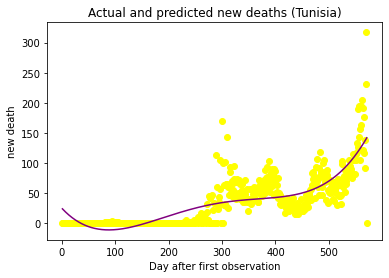

In [1285]:
#plotting the model
fig11=plt.figure()
plt.scatter(xt_nd,yt_nd, c='yellow')
plt.title("Actual and predicted new deaths (Tunisia)")
plt.xlabel("Day after first observation")
plt.ylabel("new death")
plt.plot(xt_nd, modelt_nd.predict(polyt_nd.fit_transform(xt_nd)), color="purple")

*cumulative deaths*

In [1286]:
#choosing the target and the feature
xt_cd=dft_cd.iloc[:,[1]].values
yt_cd=dft_cd.iloc[:,[0]].values

In [1287]:
#splitting the data
xt_train_cd,xt_test_cd,yt_train_cd,yt_test_cd=train_test_split(xt_cd,yt_cd,test_size=0.30,random_state=40)

In [1288]:
#fitting the feature
polyt_cd=PolynomialFeatures(degree=2)

xt_train_cd_fit=polyt_cd.fit_transform(xt_train_cd)
xt_test_cd_fit=polyt_cd.fit_transform(xt_test_cd)

In [1289]:
#creating the regression model
modelt_cd=LinearRegression()
modelt_cd.fit(xt_train_cd_fit, yt_train_cd)

print('score:')
modelt_cd.score(xt_test_cd_fit, yt_test_cd)

score:


0.9892509435594702

In [1290]:
#calculating metrics
predt_cd=modelt_cd.predict(xt_test_cd_fit)
print("MSE:", mean_squared_error(yt_test_cd,predt_cd))
print("R2:", r2_score(yt_test_cd,predt_cd))

MSE: 286801.3764223027
R2: 0.9892509435594702


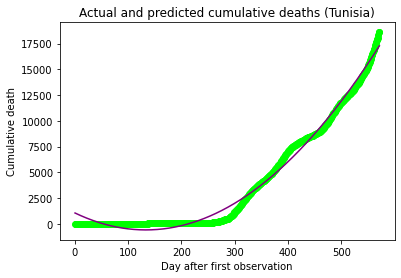

In [1291]:
#plotting the model
fig12=plt.figure()
plt.scatter(xt_cd,yt_cd, c='lime')
plt.title("Actual and predicted cumulative deaths (Tunisia)")
plt.xlabel("Day after first observation")
plt.ylabel("Cumulative death")
plt.plot(xt_cd, modelt_cd.predict(polyt_cd.fit_transform(xt_cd)), color="purple")

# **Experimentation**

In [1292]:
print(90*'-')
print('COVID-19 Propagation predictor'.center(85))
print(90*'-', end='\n\n\n')

print(38*'-', 'DESCRIPTION', 39*'-', end='\n\n')
print("""Given a choice between global (g) and Tunisia (t) and an integer n,
the predictor uses a set of regression models in order to:
>>Predict new cases n days after the day when the last observation was made.
>>Predict Cumulative cases n days after the day when the last observation was made.
>>Predict new deaths n days after the day when the last observation was made.
>>Predict cumulative deaths n days after the day when the last observation was made.

NOTE: Download and use the latest dataset using the link:'https://covid19.who.int/WHO-COVID-19-global-data.csv' 
NOTE: In order to get the most precise prediction, n should be between 1 and 30 inclusive.
""", end='\n\n')
print(39*'-', 'PREDICTION', 39*'-', end='\n\n')
date = df.iloc[-1, 0]
print('Last observation was made on: {0}.'.format(date), end='\n\n')

decision=0
while True:
  area=input("Enter g for global Covid-19 prediction, or t for local Covid-19 prediction in Tunisia: ")
  if area in 'gG':
    decision=1
    break
  elif area in 'tT':
    decision=2
    break
  else:
    print('Please, enter a valid character.')
    continue

while True:
  try:
    n=int(input("Enter an integer n where n = number of days after last observation day: "))
    break
  except:
    print('Please, enter a valid integer.')
    continue

if n<1 or n>30:
  print("WARNING: The integer n should be between 1 and 30 inclusive.")
print('\n\n')

if decision==1:
  print('GLOBAL COVID-19 PREDICTION:')
  print('New cases after {0} days from last observation: {1}'.format(n, int(model_nc.predict(poly_nc.fit_transform([[obs+n]])))))
  print('New deaths after {0} days from last observation: {1}'.format(n, int(model_nd.predict(poly_nd.fit_transform([[obs+n]])))))
  print('Cumulative cases after {0} days from last observation: {1} Millions'.format(n, round(int(model_cc.predict(poly_cc.fit_transform([[obs+n]])))/1000000,2)))
  print('Cumulative deaths after {0} days from last observation: {1}K'.format(n, round(int(model_cd.predict(poly_cd.fit_transform([[obs+n]])))/1000,2)))
else:
  print('LOCAL COVID-19 PREDICTION (TUNISIA):')
  print('New cases after {0} days from last observation: {1}'.format(n, int(modelt_nc.predict(polyt_nc.fit_transform([[obs+n]])))))
  print('New deaths after {0} days from last observation: {1}'.format(n, int(modelt_nd.predict(polyt_nd.fit_transform([[obs+n]])))))
  print('Cumulative cases after {0} days from last observation: {1}'.format(n, int(modelt_cc.predict(polyt_cc.fit_transform([[obs+n]])))))
  print('Cumulative deaths after {0} days from last observation: {1}'.format(n, int(modelt_cd.predict(polyt_cd.fit_transform([[obs+n]])))))

------------------------------------------------------------------------------------------
                            COVID-19 Propagation predictor                           
------------------------------------------------------------------------------------------


-------------------------------------- DESCRIPTION ---------------------------------------

Given a choice between global (g) and Tunisia (t) and an integer n,
the predictor uses a set of regression models in order to:
>>Predict new cases n days after the day when the last observation was made.
>>Predict Cumulative cases n days after the day when the last observation was made.
>>Predict new deaths n days after the day when the last observation was made.
>>Predict cumulative deaths n days after the day when the last observation was made.

NOTE: Download and use the latest dataset using the link:'https://covid19.who.int/WHO-COVID-19-global-data.csv' 
NOTE: In order to get the most precise prediction, n should be between 1 